In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install mediapipe

     |████████████████████████████████| 32.8 MB 210 kB/s 


In [3]:
# openCV + mediapipe
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

import numpy as np
import pandas as pd
import csv

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=(0,0,0))
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,max_num_faces=1,min_detection_confidence=0.5)

In [5]:
height,width = 576,768
image = cv2.imread("/content/drive/MyDrive/data/KakaoTalk_20211117_132105511.jpg")
image = cv2.resize(image,(width,height))

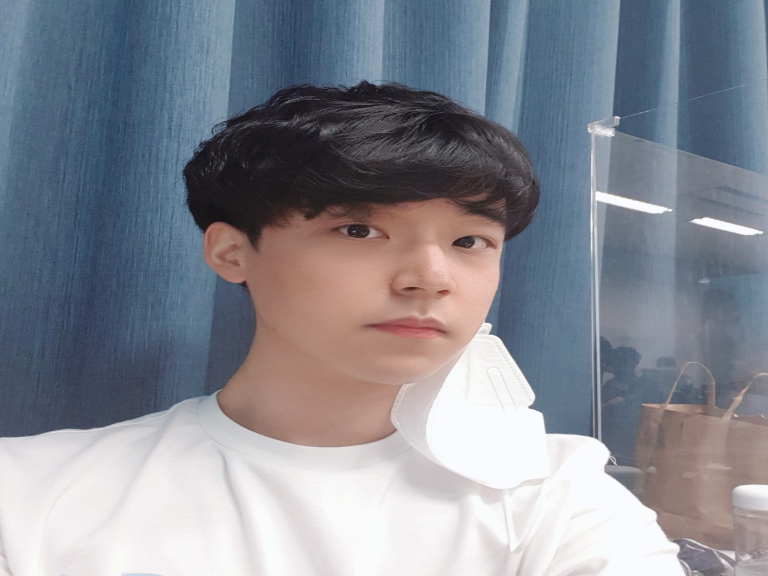

In [6]:
cv2_imshow(image)

In [7]:
results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
black_image = np.zeros((height,width,3), np.uint8)
black_image[::,::] = (230,230,230)

In [8]:
if results.multi_face_landmarks:
  for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
          image=black_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=drawing_spec,
          connection_drawing_spec=drawing_spec)

In [9]:
# CSV파일
landmarks = {}
ids = []
coordinates = []

with open('/content/drive/MyDrive/광인사 팀프로젝트/기업 프로젝트_여보야/21 여보야_코드/얼굴상 동물상/가면적용/dog_mask.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
      if(line_count != 0):
          landmarks[line_count] = {'id': int(row[0]),
                                    'x' : int(row[1]),
                                    'y' : int(row[2])}
          ids.append(int(row[0]))
          coordinates.append([int(row[1]),int(row[2])])

      line_count += 1

In [10]:
landmarks_coordinates = []
for landmark_of_interest in ids:
    x = int(face_landmarks.landmark[landmark_of_interest].x*width)
    y = int(face_landmarks.landmark[landmark_of_interest].y*height)
    landmarks_coordinates.append([x,y])

In [11]:
# pts_src(가면 점) - pts_dst(얼굴 점)
# cv2.findHomography - 특징점 검출
# cv2.warpPerspective -  원근 변환 함수

In [12]:
im_src = cv2.imread('/content/drive/MyDrive/광인사 팀프로젝트/기업 프로젝트_여보야/21 여보야_코드/얼굴상 동물상/가면적용/dog_mask_b.png', cv2.IMREAD_UNCHANGED)
pts_src = np.array(coordinates, dtype=float)
pts_dst = np.array(landmarks_coordinates, dtype=float)
h, status = cv2.findHomography(pts_src, pts_dst)

im_out = cv2.warpPerspective(im_src, h, ((image.shape[1]),(image.shape[0])))

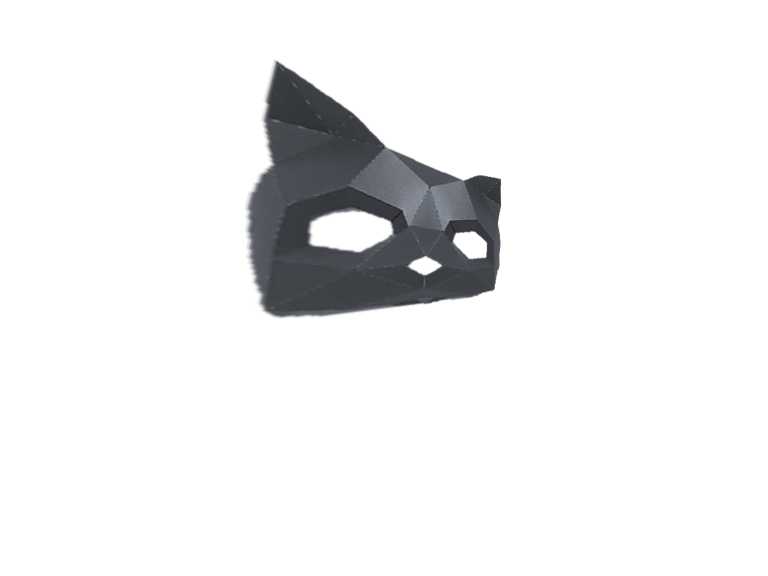

In [13]:
cv2_imshow(im_out)

In [14]:
# overlay
def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [15]:
overlay = overlay_transparent(image, im_out, 0, 0)

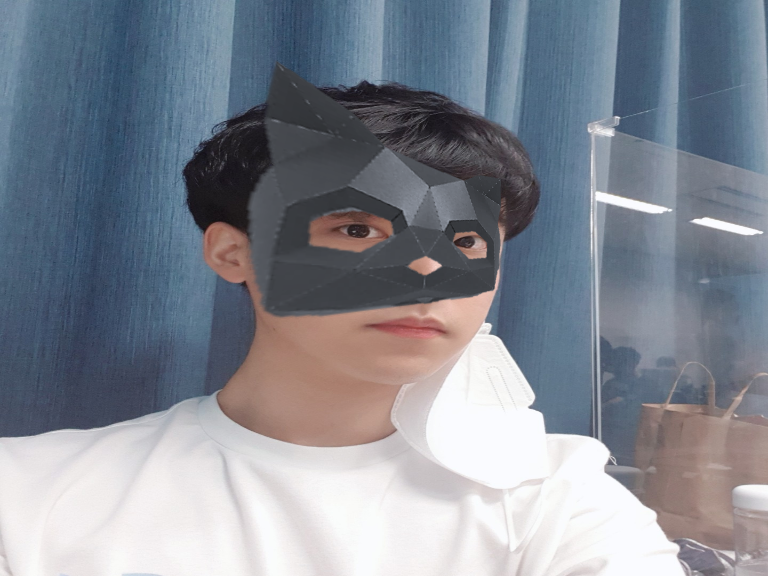

In [16]:
cv2_imshow(overlay)